In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge

from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

%matplotlib inline
plt.style.use('ggplot')


import warnings
warnings.filterwarnings(action="ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



Считаем наши данные:

In [2]:
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
train = pd.read_csv(train_file_path)
test = pd.read_csv(test_file_path);

In [3]:
def RMSE_log(y, y_pred):
    return mean_squared_error(np.log(y+1), np.log(y_pred+1), squared=False)

In [4]:
df = pd.concat([train.iloc[:,:-1], test],axis=0, ignore_index=True)
df = df.replace(to_replace='None', value=np.nan)

In [5]:
name_columns= df.columns
categ_column = []
missing = {} 
for column in name_columns:
    missing[column] = np.mean(df[column].isnull())

Определим процент пропусков в каждом из признаков. Примеры с наибольшими показателеми будем удалять(в виду заведомо низкой информативности). Примеры же с небольшим количеством пропусков заменять средним или наиболее встречаемым в остальных записях.

In [6]:
sort = dict(sorted(missing.items(), key= lambda item: item[1], reverse=True))
df = df.drop(['Fence','Alley','MiscFeature','PoolQC', 'MasVnrType'], axis=1)

name_columns_miss = list(sort.keys())[5:34]

for column in name_columns_miss:
    if ((df[column].dtype == np.float64) or (df[column].dtype == np.int64)):
        median = df[column].median()
        df[column] = df[column].fillna(median)
    else:
        top = df[column].describe()['top']
        df[column] = df[column].fillna(top)

df = df.drop(['Id'], axis=1);

In [7]:
df.isnull().sum().sum()

0

Разделим признаки на численные и категориальные. Посмотрим, есть ли в нашей выборке выбросы(опредлим выброс как значение в 10 раз больше граничного в 75% всех объектов) 

In [8]:
name_columns = df.columns
categ_column = []
for column in name_columns: 
    if (df[column].dtype == np.object_):
        categ_column.append(column)
df_cat = df[categ_column]
df_number = df.drop(categ_column, axis=1)

for column in df_number.columns:
    describe = list(df_number[column].describe())
    if ((describe[6] != 0) and (describe[7]/describe[6] > 10)):
        column_out = column

Численные признаки стандартизируем(#формулы). Категориальные же признаки будет кодировать с помощью OneHotEncoder.

In [9]:
#y= df_number['SalePrice']
#df_number = df_number.drop(['SalePrice'], axis=1)

scaler = StandardScaler()
scaler.fit(df_number)

df_number_standart = pd.DataFrame(scaler.transform(df_number), columns=df_number.columns)
df_number_standart

enc = OneHotEncoder()
df_cat_coder = enc.fit_transform(df_cat)
categ = list(enc.categories_)
new_columns = []

for i in range(len(categ)):
    new_columns.extend(categ[i])

df_cat_coder = pd.DataFrame(df_cat_coder.toarray(), columns=new_columns)

In [10]:
ss = StandardScaler()
df_cat_coder.columns = df_cat_coder.columns.astype('str')

df_cat_standart = pd.DataFrame(ss.fit_transform(df_cat_coder), columns=df_cat_coder.columns)
X = pd.concat([df_number_standart, df_cat_standart], axis=1)

In [11]:
y = train['SalePrice']

Посмотрим на выбранные нами модели:

In [12]:
Test = X.iloc[1460: , :]
X = X.iloc[:1460, :]

In [13]:
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [14]:
X

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,ConLw,New,Oth,WD,Abnorml,AdjLand,Alloca,Family,Normal,Partial
0,0.067331,-0.191815,-0.217879,0.646183,-0.507284,1.046258,0.896833,0.529034,0.580959,-0.293025,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1,-0.873616,0.511940,-0.072044,-0.063185,2.188279,0.154764,-0.395604,-0.567016,1.178162,-0.293025,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2,0.067331,-0.051064,0.137197,0.646183,-0.507284,0.980221,0.848965,0.338903,0.097928,-0.293025,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
3,0.302568,-0.426400,-0.078385,0.646183,-0.507284,-1.859351,-0.682812,-0.567016,-0.494884,-0.293025,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
4,0.067331,0.699608,0.518903,1.355551,-0.507284,0.947203,0.753229,1.390216,0.468984,-0.293025,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.067331,-0.332566,-0.285470,-0.063185,-0.507284,0.914184,0.753229,-0.567016,-0.969133,-0.293025,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1456,-0.873616,0.746525,0.381311,-0.063185,0.391237,0.220801,0.178812,0.098443,0.765389,0.670616,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1457,0.302568,-0.144898,-0.142806,0.646183,3.086800,-1.000876,1.040437,-0.567016,-0.365344,-0.293025,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1458,-0.873616,-0.051064,-0.057207,-0.772552,0.391237,-0.703711,0.561757,-0.567016,-0.861549,5.790328,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


In [15]:
from sklearn.model_selection import train_test_split 
param_grid_ = np.linspace(100, 3000, 100)
arr_test_ridge = []
arr_train_ridge = []

arr_test = []
arr_train = []
for alpha in param_grid_:
    alpha = int(alpha)
    kf = KFold(n_splits=5, shuffle=True)
    rl = Ridge(alpha=alpha)
    arr_test = []
    arr_train = []
    for tr_index, test_index in kf.split(X,y):
        X_train, X_test = X.iloc[tr_index], X.iloc[test_index]
        y_train, y_test = y[tr_index], y[test_index]
        rl.fit(X_train, y_train)
        y_log_train = np.log(rl.predict(X_train))
        y_log_test = np.log(rl.predict(X_test))
        y_log_test[np.isnan(y_log_test)] = np.nanmedian(y_log_test)        
        y_log_train[np.isnan(y_log_train)] = np.nanmedian(y_log_train)
        arr_train.append(mean_squared_error(y_log_train, np.log(y_train), squared=False))
        arr_test.append(mean_squared_error(y_log_test, np.log(y_test), squared=False))
    arr_test_ridge.append(np.mean(arr_test))
    arr_train_ridge.append(np.mean(arr_train))

744

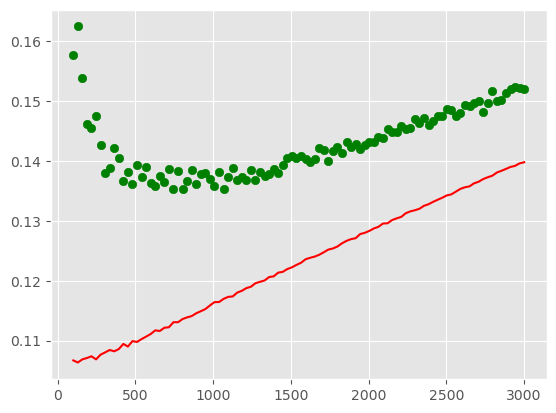

In [16]:
plt.plot(param_grid_, arr_train_ridge, c='r')
plt.scatter(param_grid_, arr_test_ridge, c='g')
np.min(arr_test_ridge), np.min(arr_train_ridge)
alpha_best = int(param_grid_[np.argmin(arr_test_ridge)])
alpha_best

In [17]:
param_grid_ = {'alpha':np.linspace(100, 1500, 90)}
rl = Ridge()
kf = KFold(n_splits=5, shuffle=True)
gs = GridSearchCV(param_grid=param_grid_, estimator=rl, cv=kf)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': array([ 100.        ,  115.73033708,  131.46067416,  147.19101124,
        162.92134831,  178.65168539,  194.38202247,  210.11235955,
        225.84269663,  241.57303371,  257.30337079,  273.03370787,
        288.76404494,  304.49438202,  320.2247191 ,  335.95505618,
        351.68539326,  367.41573034,  383.14606742,  39...
       1106.74157303, 1122.47191011, 1138.20224719, 1153.93258427,
       1169.66292135, 1185.39325843, 1201.12359551, 1216.85393258,
       1232.58426966, 1248.31460674, 1264.04494382, 1279.7752809 ,
       1295.50561798, 1311.23595506, 1326.96629213, 1342.69662921,
       1358.42696629, 1374.15730337, 1389.88764045, 1405.61797753,
       1421.34831461, 1437.07865169, 1452.80898876, 1468.53932584,
       1484.26966292, 1500.        ])})

In [19]:
rl = Ridge(alpha=gs.best_params_['alpha']).fit(X_train, y_train)
RMSE_log(rl.predict(X_test), y_test)
gs.best_score_, gs.best_params_
alpha_best = int((alpha_best + gs.best_params_['alpha'])/2)

In [20]:
alpha_best, gs.best_params_['alpha'], gs.best_score_

(453, 162.92134831460675, 0.8914160868359854)

In [21]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score
param_grid_ = np.linspace(50, 200, 20)
arr_test_ridge = []
arr_train_ridge = []

arr_test = []
arr_train = []
for alpha in param_grid_:
    alpha = int(alpha)
    kf = KFold(n_splits=5, shuffle=True)
    rl = GradientBoostingRegressor(n_estimators=alpha)
    arr_test = []
    arr_train = []
    for tr_index, test_index in kf.split(X,y):
        X_train, X_test = X.iloc[tr_index], X.iloc[test_index]
        y_train, y_test = y[tr_index], y[test_index]
        rl.fit(X_train, y_train)
        y_log_train = np.log(rl.predict(X_train))
        y_log_test = np.log(rl.predict(X_test))
        y_log_test[np.isnan(y_log_test)] = np.nanmedian(y_log_test)        
        y_log_train[np.isnan(y_log_train)] = np.nanmedian(y_log_train)
        arr_train.append(mean_squared_error(y_log_train, np.log(y_train), squared=False))
        arr_test.append(mean_squared_error(y_log_test, np.log(y_test), squared=False))
    arr_test_ridge.append(np.mean(arr_test))
    arr_train_ridge.append(np.mean(arr_train))

(0.12767711577221713, 0.06666106644731049)

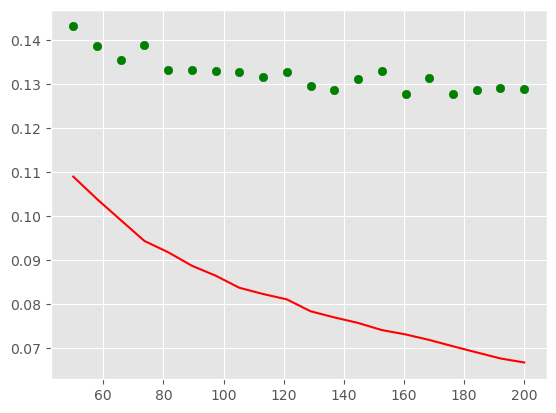

In [22]:
plt.plot(param_grid_, arr_train_ridge, c='r')
plt.scatter(param_grid_, arr_test_ridge, c='g')
np.min(arr_test_ridge), np.min(arr_train_ridge)

In [23]:
from sklearn.model_selection import train_test_split 
param_grid_ = np.linspace(50, 200, 35)
arr_test_ridge = []
arr_train_ridge = []

arr_test = []
arr_train = []
for alpha in param_grid_:
    alpha = int(alpha)
    kf = KFold(n_splits=5, shuffle=True)
    rl = GradientBoostingRegressor(n_estimators=alpha, max_depth=2)
    arr_test = []
    arr_train = []
    for tr_index, test_index in kf.split(X,y):
        X_train, X_test = X.iloc[tr_index], X.iloc[test_index]
        y_train, y_test = y[tr_index], y[test_index]
        rl.fit(X_train, y_train)
        y_log_train = np.log(rl.predict(X_train))
        y_log_test = np.log(rl.predict(X_test))
        y_log_test[np.isnan(y_log_test)] = np.nanmedian(y_log_test)        
        y_log_train[np.isnan(y_log_train)] = np.nanmedian(y_log_train)
        arr_train.append(mean_squared_error(y_log_train, np.log(y_train), squared=False))
        arr_test.append(mean_squared_error(y_log_test, np.log(y_test), squared=False))
    arr_test_ridge.append(np.mean(arr_test))
    arr_train_ridge.append(np.mean(arr_train))

(0.12849669117993953, 0.09301287730884804)

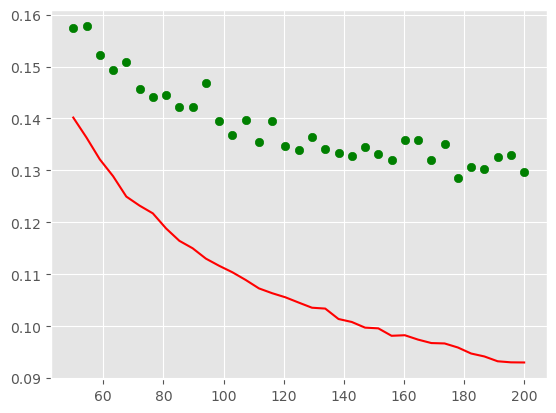

In [24]:
plt.plot(param_grid_, arr_train_ridge, c='r')
plt.scatter(param_grid_, arr_test_ridge, c='g')
np.min(arr_test_ridge), np.min(arr_train_ridge)

In [25]:
from sklearn.metrics import mean_squared_error
param_grid_gb ={'n_estimators':[ 90, 105, 120, 135, 150], 'max_depth': [1, 2]}

kf = KFold(n_splits=5, shuffle=True)
gb=GradientBoostingRegressor()
gs_gb = GridSearchCV(estimator=gb, cv=kf, param_grid=param_grid_gb)
gs_gb.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [1, 2],
                         'n_estimators': [90, 105, 120, 135, 150]})

In [26]:
gs_gb.best_params_, gs_gb.best_score_

({'max_depth': 2, 'n_estimators': 150}, 0.8305682805378627)

In [27]:
xgb = XGBRegressor()
param_grid_gb ={'n_estimators':[ 90, 105, 120, 135, 150], 'max_depth': [1, 2]}

kf = KFold(n_splits=5, shuffle=True)
gs_xgb = GridSearchCV(estimator=xgb, cv=kf, param_grid=param_grid_gb)

In [28]:
X.columns = np.linspace(0, 270, 271)
gs_xgb.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    in...one,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'max_depth': [1, 2],
                         'n_estimators': [90, 105, 120, 135, 150]})

In [29]:
gs_xgb.best_params_, gs_xgb.best_score_

({'max_depth': 2, 'n_estimators': 150}, 0.8758682874252621)

Итак, лучшие параметры для Ridge регресии 700, для GradientBoosting and Xgboost {'max_depth': 2, 'n_estimators': 150}

In [30]:
gb = GradientBoostingRegressor(max_depth=2, n_estimators=150)

In [37]:
rl = Ridge(alpha=700)

In [38]:
xgb = XGBRegressor(n_estimators= 150, max_depth= 2)

Посмотрим, улучшает ли усреднение моделей наше предсказание:

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

rl.fit(X_train, y_train)
gb.fit(X_train, y_train)
xgb.fit(X_train, y_train)

pred_gb = gb.predict(X_test)
pred_rl = rl.predict(X_test)
pred_xgb = xgb.predict(X_test)
pred = (pred_gb + pred_xgb)/2

print(RMSE_log(pred, y_test), RMSE_log(pred_gb, y_test), RMSE_log(pred_rl, y_test), RMSE_log(pred_xgb, y_test))

0.12507246773847946 0.12712665406596707 0.13275995902926918 0.13043378862960617


Как мы видим линейная регрессия достаточно неустойчивая. Она также проседает RMSE_log по сравнению с градиентным бустингом.

In [40]:
gb = GradientBoostingRegressor(max_depth=2, n_estimators=150)
xgb = XGBRegressor(max_depth=2, n_estimators=150)
rl = Ridge(alpha = 700)
xgb.fit(X, y)
gb.fit(X, y)
rl.fit(X, y)

Ridge(alpha=700)

In [41]:
Test.columns = np.linspace(0, 270, 271)
pred = (xgb.predict(Test) + gb.predict(Test) + rl.predict(Test))/3
id_ = np.linspace(1461, 2919, len(pred))
submission = {
    'Id': id_, 
    'SalePrice': pred
}

solution = pd.DataFrame(submission)
solution['Id'] = solution['Id'].astype('int')
solution.to_csv('submission.csv',index=False)

Решение было загружено на kaggle. С оценкой Score: 0.13113 и 809 местом

In [42]:
solution

,Id,SalePrice
0,1461,113585.839183
1,1462,158135.963147
2,1463,184205.598606
3,1464,191288.059740
4,1465,200678.537743
...,...,...
1454,2915,82954.922657
1455,2916,83546.201270
1456,2917,170835.119457
1457,2918,120620.334444
